In [66]:
#Stacked Regressions to predict House Prices
# All belongs to the bottom link. I am only implementing to understand
#Do not forget to visit the page and give up to @Serigne's wonderful notebook 
#https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
#xgboost ve lightgbm ayrı kurulum gerektirdiği için o kısımları kodlarını yorum olarak bıraktım.
#Do not forget if you re-run a cell which includes a deletion operation. You will probably get "element can not be found" error.    

In [14]:
import numpy as np # linear cebir için
import pandas as pd # veri işleme, CSV dosyaları girdi/çıktı (örn. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab stilinde grafik çizmek için
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #Sklearn ve seaborn'un verdiği cansıkıcı uyarıları engellemek için


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Float çıktıları 3 basamakla sınırlandırmak için

In [15]:
#Dosyaları yükle
#Train tüm verilerimiz. Test ise belli bir kısmı
train = pd.read_csv('C:/Users/CAHİT BARKIN ÖZER/train.csv')
test = pd.read_csv('C:/Users/CAHİT BARKIN ÖZER/test.csv')

In [16]:
#Uygulanacak işlemler genel olarak
# Verilerin genel analizi(verinin tanımı,verilerin birkaç satırı,verilerin satır sütun sayıları,
#sütunların ilişkileri incelenir)> Verilerin temizlenmesi(aykırı ve boş değerlere müdahale)>Modelleme ve modellerin test edilip
# birbirileri ile karşılaştırılmaları ardından en uygunlarının seçilip yığılması

#ilk 5 elemanı göster
train.head(5)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [17]:
#İlk 5 elemanı göster
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [18]:
#boyutlarına bak
train.shape

(1460, 81)

In [19]:
#boyutlarına bak
test.shape

(1459, 80)

In [20]:
#'Id' sütununu kaydet
train_ID = train['Id']
test_ID = test['Id']

In [21]:
#'Id' sütunu gereksiz bu yüzden sil
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [22]:
#silme başarılı
train.shape

(1460, 80)

In [23]:
#silme başarılı
test.shape

(1459, 79)

In [24]:
#Data Processing

In [25]:
#Aykırı değerler

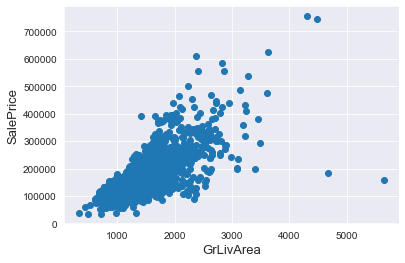

In [26]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13) # y eksenine yaz
plt.xlabel('GrLivArea', fontsize=13) #x eksenine yaz
plt.show()
#En sağ en altta 2 değer aykırı. Yaşam alanı ile fiyatın 
#mantık olarak ve grafikten de gözükeceği üzere doğru orantılı olması beklenir. Bu değerler tarlalı köy evi olabilir.

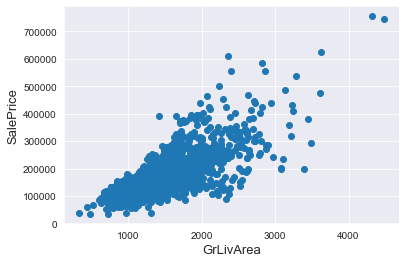

In [27]:
#Verimizden istenilen aralık dışında kalan aykırı değerler(outliers) siliniyor
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Grafiğe tekrar bakılıyor
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()
#Not silme işlemi güvenli değildir ancak bu durumda çok bariz aykırıydılar.


 mu = 180932.92 and sigma = 79467.79



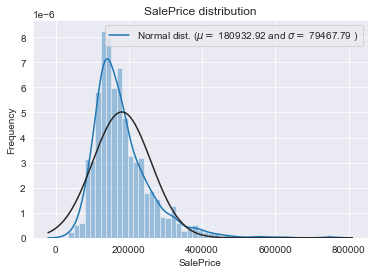

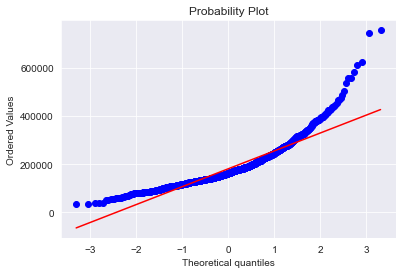

In [28]:
#Hedef değişkenimiz 'SalePrice'. Hadi onu biraz tanıyalım.

sns.distplot(train['SalePrice'] , fit=norm);

# Fonksiyonun kullandığı parametreleri alalım
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Dağılımı çizelim
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#QQ çizimini de alalım
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


 mu = 12.02 and sigma = 0.40



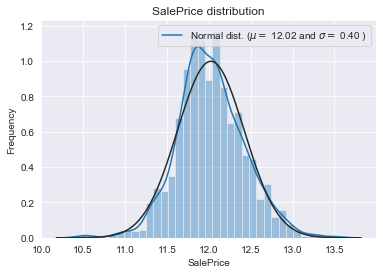

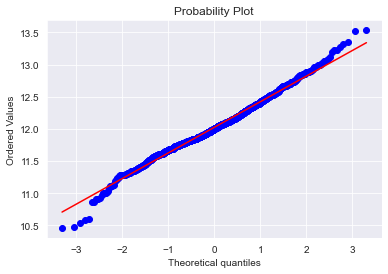

In [29]:
# Hedef değişkenimiz sağa meyilli. Doğrusal modeller normal dağılmış verileri sevdiği için, 
# değişkeni dönüştürmemiz ve onu daha normal dağıtılmış hale getirmemiz gerekir.

# Hedef değişkene logaritmik dönüşüm uyguluyoruz
#numpy fonksiyonu olan log1p ile sütunun her elemanına log(1+x) işlemini uyguluyoruz
train["SalePrice"] = np.log1p(train["SalePrice"])

#Yeni dağılımı kontrol et 
sns.distplot(train['SalePrice'] , fit=norm);

# En uygun parametreleri al
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Dağılımı çiz
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#QQ çizimini de alalım
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [30]:
#Özellik mühendisliği

# Train ve test verilerini aynı dataframe içerisine birleştiriyoruz
ntrain = train.shape[0]
ntest = test.shape[0]

y_train = train.SalePrice.values
#birleştirme işlemi
all_data = pd.concat((train, test)).reset_index(drop=True)
#'SalePrice' sütununu siliyoruz
all_data.drop(['SalePrice'], axis=1, inplace=True)

#Tüm datanın büyüklüğü
print("all_data büyüklüğü : {}".format(all_data.shape))

all_data büyüklüğü : (2917, 79)


In [31]:
#Eksik veriler
#Tüm veriye oranla eksiklik yüzdesi veriyoruz
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
#Eksik veriler adında bir tablo oluşturuyoruz
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
#İlk 20 satıra bakıyoruz
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageYrBlt,5.451
GarageQual,5.451
GarageCond,5.451


Text(0.5, 1.0, 'Özellik başına eksik veri oranı')

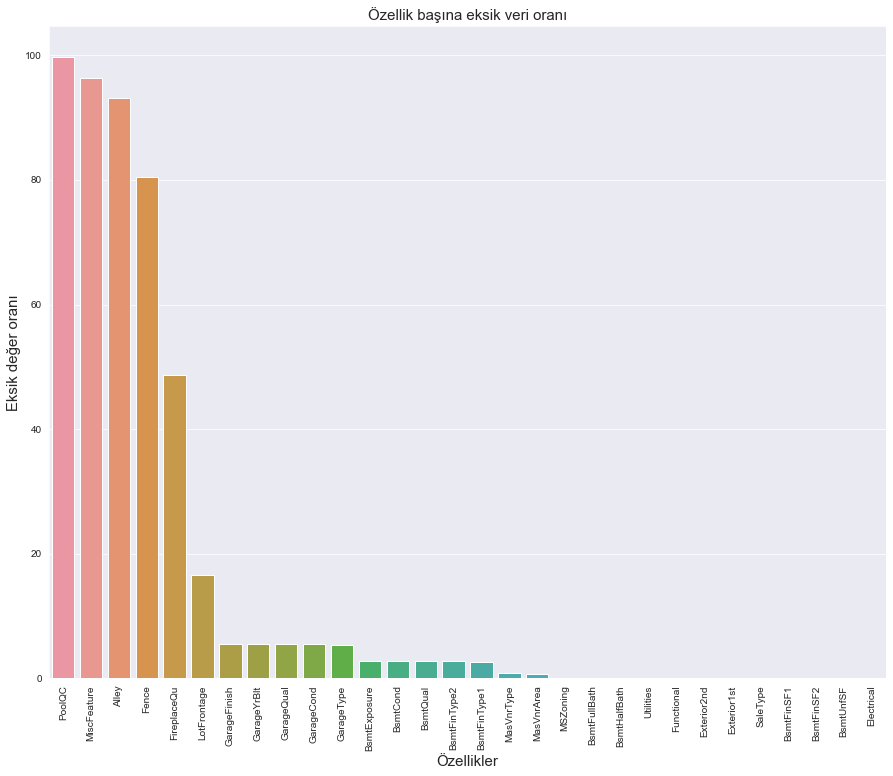

In [32]:
#Eksik veriyi tabloda gösteriyoruz
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Özellikler', fontsize=15)
plt.ylabel('Eksik değer oranı', fontsize=15)
plt.title('Özellik başına eksik veri oranı', fontsize=15)

<AxesSubplot:>

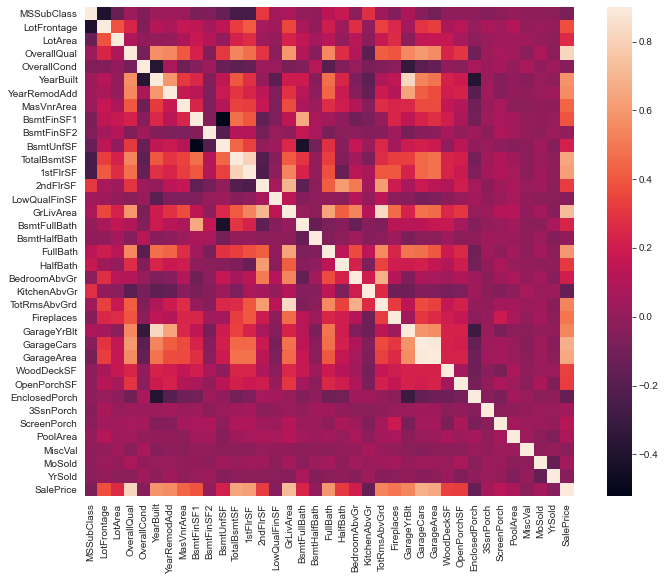

In [33]:
#Veri korelasyonu
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [34]:
#Eksik değerlerin üstünden sırasıyla giderek onları itham ediyoruz. Eksik veriler için birkaç farklı işlem seçeneğimiz bulunur.
# Çoğu eksikse o sütunu silmek. Eksik kısımlara ortalama bir değer vermek(modelimize etki etmesin diye).
# İleri derece işlemlerde boş değerleri regresyon ile tahmin etmektir.
#Bunun kararına mantığımız ile ulaşırız.

#PoolQC : veri tanımı NA(eksik veri)'nin "havuz yok" anlamına geldiğini belirtmiş.
#Eksik değerleri boş değer ile değiştiriyoruz
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

#MiscFeature : veri tanımı NA(eksik veri)'nin "çeşit yok" anlamına geldiğini belirtmiş.
#Eksik değerleri boş değer ile değiştiriyoruz
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

#Alley : veri tanımı NA(eksik veri)'nin "yol yok" anlamına geldiğini belirtmiş.
#Eksik değerleri boş değer ile değiştiriyoruz
all_data["Alley"] = all_data["Alley"].fillna("None")

#Fence : veri tanımı NA(eksik veri)'nin "çit yok" anlamına geldiğini belirtmiş.
#Eksik değerleri boş değer ile değiştiriyoruz
all_data["Fence"] = all_data["Fence"].fillna("None")

#FireplaceQu : veri tanımı NA(eksik veri)'nin "şömine yok" anlamına geldiğini belirtmiş.
#Eksik değerleri boş değer ile değiştiriyoruz
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

#LotFrontage: Ev mülküne bağlı her bir caddenin alanı büyük olasılıkla mahallesindeki diğer evlere benzer 
#bir alana sahip olduğundan, eksik değerleri mahallenin LotFrontage medyanı ile doldurabiliriz.
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [35]:
#GarageType, GarageFinish, GarageQual and GarageCond : Garajla alakalı.Garajı olmayan evlerin verisi eksik kalmış.
#Eksik değerler boş değer ile değiştiriliyor
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
    
# Aynı şekilde garajı olmayan evlerin boş kalmış
#Eksik değerler boş değer ile değiştiriliyor
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)    

#BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath. Bodrum katı olmayan evlerin verileri boş kalmış.
#Eksik değerler boş değer ile değiştiriliyor
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
    
#MasVnrArea and MasVnrType : NA muhtemelen bu evlerde duvar kaplama olmadığı anlamına geliyor.
#Alan için 0 tip için boş değer yazıyoruz.
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [36]:
#MSZoning (genel bölge sınıflandırması) : 'RL' en sık görülen değer. Bu yüzden geri kalanı da 'RL' ile dolduruyoruz.
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
#Yardımcılar: Bu değişken için tüm veri tipleri 2 NA ve bir tane 'NoSeWa' haricinde 'AllPub'dır.
#Eğitimde bir amacı olmayacağı için siliyoruz.
all_data = all_data.drop(['Utilities'], axis=1)
#Functional : veri açıklaması  NA'Nin tipik demek olduğunu söylüyor. Bu nedenle onu typ(typical) ile değiştiriyoruz.
all_data["Functional"] = all_data["Functional"].fillna("Typ")
#Electrical:'SBrkr' çok sık görülüyor diye boş değerlere de yazıyoruz.
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
#KitchenQual: Sadece 1 eksik değer var gerisi 'TA' bu yüzden ona da TA yazıyoruz.
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
#Exterior1st and Exterior2nd : Yine 2 NA değer var onları en sık olan ile değiştiriyoruz.(Modelimizi etkilemeyecektir)
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
#SaleType : Yine en sık olan "WD" ile dğeiştiriyoruz.
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
#MSSubClass : Na muhtemelen hiç yok demek bu yüzden none ile değiştiriyoruz.
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")
#Geriye kalan eksik değer var mı diye kontrol edilir
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [37]:
#Aslında kategorik olan bazı sayısal değişkenleri kategoriklere dönüştürüyoruz

#MSSubClass=Bina sınıfı
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#OverallCond'u kategorik yapıyoruz
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month'u kategorik yapıyoruz.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [38]:
#Sıralama kümelerinde bilgi içerebilecek bazı kategorik değişkenleri kodluyoruz(encoding)
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# Sütunlar işleme sokulur,LabelEncoder kategorik değerlere uygulanır
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# satır sütun şekli       
print('all_data şekli: {}'.format(all_data.shape))

all_data şekli: (2917, 78)


In [39]:
#Alan ile ilgili değişkenlerin SalePrice üzerindeki yüksek etkisini görmüştük. Bu nedenle bodrum ve ilk iki katın toplam alanını
#ifade eden bir sütun ekliyoruz 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [40]:
#Çarpık değerler
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Tüm sayısal değerlerdeki çarpıklığa bakıyoruz
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nNumerical özelliklerdeki çarpıklık: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Numerical özelliklerdeki çarpıklık: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


In [41]:
#Fazla çarpık değerlerimize Box Cox dönüşümü uygulayacağız.
#scipy kütüphanesinden boxcox1p fonksiyonunu kullanacağız.(1+x'in box cox dönüşümünü bulacak)
#Dikkat edin ki λ=0 yaparsak yukarıda kullandığımız log1p fonksiyonunu elde ederiz
skewness = skewness[abs(skewness) > 0.75]
print("Box Cox dönüşümünde {} çarpık numerik özellik bulunuyor".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

Box Cox dönüşümünde 59 çarpık numerik özellik bulunuyor


In [42]:
#Sahte kategorik verileri alıyoruz
all_data = pd.get_dummies(all_data)
print(all_data.shape)
#Yeni train ve test kümelerini alıyoruz
train = all_data[:ntrain]
test = all_data[ntrain:]

(2917, 220)


In [43]:
#Modelleme
#Kütüphaneleri ekliyoruz
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC # lineer modellerimiz
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error #Modellerin başarısını ölçmek için
#import xgboost as xgb # Son zamanlarda yüksek başarı gösteren bir model ama ayrı bir karmaşık kurulum istiyor
#import lightgbm as lgb # Aynı şekilde bir kurulum istiyor


In [44]:
#Define a cross validation strategy
#cross_val_score fonksiyonunu Sklearn kütüphanesinden kullanıyoruz ama kendi içerisinde karıştırmayı
# bulundurmuyor bu nedenle biz ayrıca manuel karıştırmayı sağlıyoruz
#Doğrulama fonksiyonu
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [45]:
#Temel modeller

In [46]:
#Lasso regresyon aykırı değerlere karşı hassas olduğu için o değerlere karşı güçlendireceğiz.
#Bunu sklearn'ün Robustscaler() fonksiyonu ile yapacağız.
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [47]:
#ElasticNet regresyonu da aynı şekilde güçlendiriyoruz.
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [48]:
#Kernel Ridge Regresyonu:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [49]:
#Gradient Boosting Regresyon :
#Aykırı değerlere karşı sağlam kılan huber kaybı ile birlikte.
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [50]:
#XGBoost: Ölçeklenebilir, Taşınabilir ve Dağıtılmış Degrade Artırıcı Kütüphane" sağlamayı amaçlamaktadır
#model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                            # learning_rate=0.05, max_depth=3, 
                            # min_child_weight=1.7817, n_estimators=2200,
                            #reg_alpha=0.4640, reg_lambda=0.8571,
                            #subsample=0.5213, silent=1,
                            #random_state =7, nthread = -1)

In [51]:
#LightGBM: LightGBM, Light Gradient Boosting Machine'in kısaltmasıdır, ilk olarak Microsoft tarafından geliştirilen
#makine öğrenimi için ücretsiz ve açık kaynaklı dağıtılmış bir gradyan artırma çerçevesidir. 
#Karar ağacı algoritmalarına dayanır ve sıralama, sınıflandırma ve diğer makine öğrenimi görevleri için kullanılır.
#model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                            #   learning_rate=0.05, n_estimators=720,
                            #  max_bin = 55, bagging_fraction = 0.8,
                            # bagging_freq = 5, feature_fraction = 0.2319,
                            #feature_fraction_seed=9, bagging_seed=9,
                            #min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [52]:
#Temel model skorları

In [53]:
#Temel modellerimizin  cross-validation rmsle(çapraz onaylama kök ortalamalar logaritmik karesi)
# hata ölçme metoduna göre başarılarını ölçeceğiz
#İşlem birkaç dakika alabilir
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

#score = rmsle_cv(model_xgb)
#print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

#score = rmsle_cv(model_lgb)
#print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)

ElasticNet score: 0.1116 (0.0074)

Kernel Ridge score: 0.1153 (0.0075)

Gradient Boosting score: 0.1167 (0.0083)



In [55]:
#Gradient Boosting 83 ile en başarılı skoru alıyor.
#Modelleri istifleme
#Veri biliminde aynı modeli defalarca kullanmak bir fayda sağlamazken
#farklı modelleri bir araya getirmek başarı sağlayabilmektedir*
#Basit yığıtlama yaklaşımı: Temel modellerin ortalamasını almak
#Scikit-learn'ü kendi modelimizle genişletmek(inheritence(miraslama) ve encapsulation(kapsülleme) yapmak)
#için yeni bir sınıf oluşturuyoruz

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    #constructor
    def __init__(self, models):
        self.models = models
        
    # Veriyi sığdırmak için orijinal modelin klonlarını oluşturuyoruz
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Klonlanmış modelleri eğitiyoruz
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Klonlanmış modeller için tahmin yapıyoruz ve ortalamasını alıyoruz
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [56]:
#Sadece 4 modelin ortalamasını alacağız isteseydik daha da fazla alabilirdik.ENet, GBoost, KRR and lasso alacağız.
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1087 (0.0077)



In [57]:
#Vaov ! En basit istifleme yaklaşımı bile skoru gerçekten artırıyor gibi görünüyor. 
#Bu, bizi daha ileri gitmeye ve daha karmaşık bir istifleme yaklaşımını keşfetmeye teşvik eder.

In [58]:
#Biraz daha karmaşık bir istifleme yöntemi: meta-model
#Bu yaklaşımda, ortalama temel modellere bir meta model ekliyoruz ve meta modelimizi eğitmek için 
#bu temel modellerin kıvrım dışı tahminlerini kullanıyoruz.

#Eğitim bölümü için prosedür şu şekilde tanımlanabilir:
#1_Toplam eğitim setini iki ayrık gruba ayırın (burada train ve .holdout)
#2_İlk bölümde birkaç temel modeli eğitin (train)
#3_Bu temel modelleri ikinci bölümde test edin (holdout)
#4_ 3. adımdaki tahminler girdi, hedef değişken çıktı  olarak kullanılarak daha üst seviye bir öğrenici olan meta-model'i eğit

In [59]:
#İlk üç adım yinelemeli olarak yapılır. Örneğin 5 katlı bir istiflemeyi ele alırsak, önce eğitim verilerini 5 kata ayırırız.
#Ardından 5 yineleme yapacağız. Her yinelemede, her temel modeli 4 kat üzerinde eğitiyoruz ve
#kalan katlamayı tahmin ediyoruz(holdout folding).

#Bu nedenle, 5 yinelemeden sonra, tüm verilerin, 4. adımda meta modelimizi eğitmek için yeni özellik olarak kullanacağımız 
#katsız tahminleri elde etmek için kullanıldığından emin olacağız.

#Tahmin kısmı için, test verileri üzerindeki tüm temel modellerin tahminlerinin ortalamasını alıyoruz ve bunları meta-model
#ile nihai tahminin yapıldığı meta-özellikler olarak kullanıyoruz.

In [60]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # Orijinal modelin klonları üzerine veriyi ekliyoruz
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        #Klon modelleri eğit sonra klonlanmış meta modelleri eğitmek için gereken
        #out-of-fold(katlama dışı kalan) tahminleri yarat 
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Klonlanmış modelleri out-of-fold tahminleri kullanarak yeni bir özellik olacak şekilde eğit
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Test verilerindeki tüm temel modellerin tahminlerini yapın ve ortalama tahminleri meta-model tarafından yapılan 
    #tahminler için meta özellikler olarak kullanın
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [61]:
#Her iki model yığıtlama modelini karşılaştırabilmek için aynı modelleri girdi olarak kullanacağız
#İşlem birkaç dakika sürebilir
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1081 (0.0073)


In [63]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))
#stacked regressor:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

#model_xgb.fit(train, y_train)
#xgb_train_pred = model_xgb.predict(train)
#xgb_pred = np.expm1(model_xgb.predict(test))
#print(rmsle(y_train, xgb_train_pred))

#model_lgb.fit(train, y_train)
#lgb_train_pred = model_lgb.predict(train)
#lgb_pred = np.expm1(model_lgb.predict(test.values))
#print(rmsle(y_train, lgb_train_pred))

#'''RMSE on the entire Train data when averaging'''

#print('RMSLE score on train data:')
#print(rmsle(y_train,stacked_train_pred*0.70 +
 #              xgb_train_pred*0.15 + lgb_train_pred*0.15 ))
#ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

0.07839506096665516


In [65]:
#Sonuçların olduğu bir tablo yapıyoruz ve bitiriyoruz
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = #ensemble
sub.to_csv('submission.csv',index=False)

SyntaxError: invalid syntax (<ipython-input-65-919fc66a7603>, line 4)